In [1]:
# Import Basic Libraries
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
import math
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xgboost as xgb

In [4]:
# Create function to calculate root mean square error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [5]:
# Read csv file
df=pd.read_csv('/home/tarunpreet/Desktop/Suraj/org_update.csv')

In [6]:
#Groupby dataframe 

newdf=df.groupby(['Month','Day']).agg({'Temp': ['mean'],'DHI':['mean'],'DNI':['mean'],'GHI':['mean'],
                                      'WindVel':['mean'],'Output_Power':['mean']})
newdf = newdf.reset_index()
newdf.columns=['Month','Day','Temp_Mean','DHI_Mean','DNI_Mean','GHI_Mean','WindVel_Mean','Output_Power_Mean']
newdf.to_csv('./avg.csv')

In [7]:
# Drop unnecessary columns in dataset
newdf1=newdf.drop(labels=['Month','Day'],axis=1)
X_data=newdf1.drop(labels=['Output_Power_Mean'],axis=1)
Y_data=newdf1['Output_Power_Mean']

In [8]:
# Scale the dataset to ensure that features are within the same scale using Standard Scaler
Xscaler = StandardScaler()
Xscaler.fit(X_data)
SXdata= Xscaler.transform(X_data)

In [9]:
Yscaler = StandardScaler()
Y_data=Y_data.to_numpy().reshape(-1,1)
Yscaler.fit(Y_data)
SYdata= Yscaler.transform(Y_data)

In [10]:
# Split data into windows

window_size=10
predictions=1
x=[]
y=[]
for i in range(0, len(newdf1.index)-10, predictions):
    x.append(SXdata[i:window_size+i])
    y.append(SYdata[window_size+i])

In [14]:
# Train Test Split
X_train,X_test,Y_train,Y_test=train_test_split(np.array(x), np.array(y),test_size=0.20,random_state=42)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(255, 10, 5) (255, 1) (64, 10, 5) (64, 1)


In [15]:
#Reshape train and test dataset for xgboost model
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (255, 50)
X_test shape: (64, 50)


In [22]:
cv = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
param_xgb = {'n_estimators': [200, 190, 180, 170, 160,150,140,130,120,110,100], 'max_depth': [6,7, 8], 'reg_lambda' :[0.25, 0.2,0.15]}
XGB_reg=GridSearchCV(xgb.XGBRegressor(), param_xgb, scoring='neg_mean_absolute_error', cv=3, return_train_score=True,n_jobs=-1)
optimized_xgb_reg=XGB_reg.fit(X_train,Y_train)
print("Best: %f using %s for %s" % (optimized_xgb_reg.best_score_,optimized_xgb_reg.best_params_,optimized_xgb_reg.best_estimator_))
model=optimized_xgb_reg.best_estimator_

Best: -0.540764 using {'max_depth': 7, 'n_estimators': 200, 'reg_lambda': 0.2} for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [23]:
model.fit(X_train, Y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
# Test the model
ytrain_pred=model.predict(X_train)
ytest_pred =model.predict(X_test)
Ytrain_pred=ytrain_pred.reshape(-1,1)
Ytest_pred=ytest_pred.reshape(-1,1)

In [25]:
# Tranform the scale data
trainPredict = Yscaler.inverse_transform(Ytrain_pred)
testPredict = Yscaler.inverse_transform(Ytest_pred)
Y_Train=Yscaler.inverse_transform(Y_train)
Y_Test = Yscaler.inverse_transform(Y_test)
print("Predicted values",testPredict)
print("Actual values",Y_Test)

Predicted values [[4285.8257  ]
 [ 866.3207  ]
 [1433.7875  ]
 [1339.7949  ]
 [1715.3164  ]
 [4471.6997  ]
 [1842.3773  ]
 [1894.5232  ]
 [3775.8953  ]
 [2158.9978  ]
 [ 457.36267 ]
 [2651.1335  ]
 [1583.748   ]
 [2358.47    ]
 [1645.688   ]
 [3035.7896  ]
 [2129.2888  ]
 [2775.5308  ]
 [ 144.4469  ]
 [2848.2966  ]
 [2185.5315  ]
 [2045.355   ]
 [1071.8708  ]
 [3075.729   ]
 [3348.905   ]
 [1988.8569  ]
 [ 181.02026 ]
 [1480.2792  ]
 [4356.524   ]
 [2040.4159  ]
 [2609.8433  ]
 [ 521.3617  ]
 [1532.0814  ]
 [ 418.0996  ]
 [ 110.232414]
 [3154.055   ]
 [ 806.10126 ]
 [1468.2576  ]
 [2656.226   ]
 [1036.0171  ]
 [ 296.80872 ]
 [2104.9653  ]
 [ 476.10413 ]
 [ 308.38586 ]
 [1310.6733  ]
 [ 694.38745 ]
 [2438.0508  ]
 [2661.2852  ]
 [1314.7725  ]
 [2923.5295  ]
 [1774.1819  ]
 [2028.2389  ]
 [1898.408   ]
 [1251.6854  ]
 [ 553.0493  ]
 [1497.0099  ]
 [2893.4602  ]
 [3237.0276  ]
 [1557.4438  ]
 [1016.64386 ]
 [1231.9893  ]
 [3969.9058  ]
 [4018.2087  ]
 [1455.6827  ]]
Actual values [[1186.9

In [26]:
# Evaluate the model using Regression Metrics
mse = mean_squared_error(Y_Test, testPredict)
mae = mean_absolute_error(Y_Test, testPredict)
mape = mean_absolute_percentage_error(Y_Test, testPredict)
rms_error = rmse(Y_Test, testPredict)
R2_score=metrics.r2_score(Y_Test, testPredict)
print('mean square error',mse)
print('mean absolute error',mae)
print('mean abs_percentage_error',mape)
print('root_mean square error',rms_error)
print('R2_score:', R2_score)

mean square error 857191.8234380368
mean absolute error 670.7281216096878
mean abs_percentage_error 0.6549420047419973
root_mean square error 925.8465442167168
R2_score: 0.4485107116527901


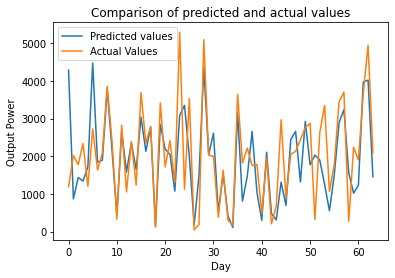

In [27]:
plt.plot(testPredict)
plt.plot(Y_Test)
plt.title('Comparison of predicted and actual values')
plt.ylabel('Output Power')
plt.xlabel('Day')
plt.legend(['Predicted values', 'Actual Values'])
plt.show()